# Classification Basics

This notebook is based on fastai's **[Chapter 5](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)**.

Please read that chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [2]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.all import *

# Data

### Download Data

In [5]:
# download data from the pet dataset
path = untar_data(URLs.PETS)
Path.BASE_PATH = path

# fastAI type L: gives number of items and first 10ish filenames
(path/"images").ls()

(#7393) [Path('images/havanese_57.jpg'),Path('images/wheaten_terrier_193.jpg'),Path('images/chihuahua_131.jpg'),Path('images/american_pit_bull_terrier_111.jpg'),Path('images/Bombay_25.jpg'),Path('images/Ragdoll_48.jpg'),Path('images/staffordshire_bull_terrier_71.jpg'),Path('images/Maine_Coon_210.jpg'),Path('images/Abyssinian_177.jpg'),Path('images/american_bulldog_71.jpg')...]

In [6]:
# extract pet breed names (part of the image file names)
fname = (path/"images").ls()[0].name
print(fname)

havanese_57.jpg


In [7]:
# regex
  # plucks out all the characters leading up to the last underscore character,
  # as long as the subsequence characters are numerical digits and then the JPEG file extension.
re.findall(r'(.+)_\d+.jpg$', fname)

['havanese']

### Create Data Block
Specific to FastAI

In [8]:
# create data block
pets = DataBlock(
  blocks = (
    ImageBlock, # type of independent variable
    CategoryBlock # type of dependent variable
  ),
  get_items=get_image_files, # how to load the data
  splitter=RandomSplitter(seed=42), # how to split the data
  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), # get labels using the regex function
  item_tfms=Resize(460), # individual image procesing -- resize all images to be the same size (for tensors)
  batch_tfms=aug_transforms(size=224, min_scale=0.75) # batch image processing -- data augmentation
)

In [9]:
# get summary of datablock-- if there are some errors, they'll appear here
# pets.summary(path/"images")

### Create Data Downloader

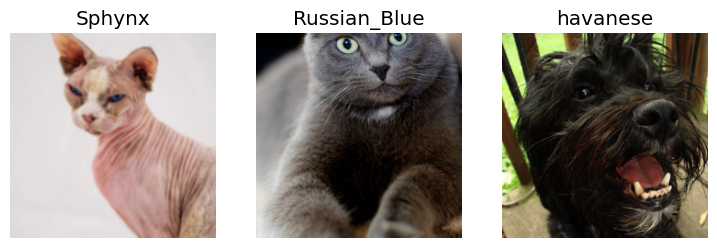

In [10]:
dls = pets.dataloaders(path/"images")

# show images that were downloaded from the data downloader
dls.show_batch(nrows=1, ncols=3)

# Aside: Data Augmentation

### Get a sample image

In [11]:
# sample image
# note -- you need your own Azure credentials

# your_secret_key = <>
# key = os.environ.get('AZURE_SEARCH_KEY', your_secret_key)
# results = search_images_bing(key, 'grizzly bear')
# ims = results.attrgot('contentUrl')
# dest = 'images/grizzly.jpg'
# download_url(ims[0], dest)

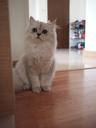

In [12]:
# sample image
im = Image.open(path/'images/Persian_120.jpg')
im.to_thumb(128,128)

### Create batches of images of that cat

In [13]:
cats = DataBlock(
  blocks=(ImageBlock(), CategoryBlock()),
  get_y=parent_label,
  item_tfms=Resize(460)
)

In [14]:
sample_cat = cats.dataloaders(
  [path/'images'/'Persian_120.jpg']*100, # repeat this image 100 times
  bs=8 # batch size 8
)

sample_cat

In [15]:
# create 1s
sample_cat.train.get_idxs = lambda: Inf.ones

### Turn a batch of cat images into a tensor

In [16]:
# get one batch into a tensor -- 8 sample_cat images stacked on each other
x,y = sample_cat.valid.one_batch()
print(x.shape, y.shape)

torch.Size([8, 3, 460, 460]) torch.Size([8])


### Transformations

#### FastAI's version

In [17]:
# set up transformations
tfms = setup_aug_tfms(
  [
    Rotate(draw=30, p=1, size=224),
    Zoom(draw=1.2, p=1., size=224),
    Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)
  ]
)

# actually do the transformations
transformed_x = Pipeline(tfms)(x)
print(transformed_x.shape)

torch.Size([8, 3, 224, 224])


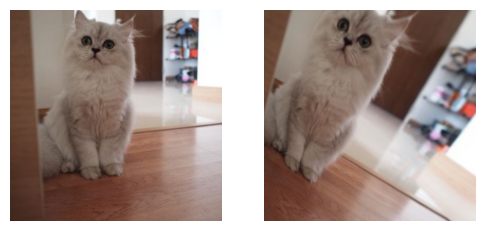

In [18]:
_,axs = subplots(1, 2)

# original image (left)
TensorImage(x[0]).show(ctx=axs[0])

# transformed image (right)
TensorImage(transformed_x[0]).show(ctx=axs[1]);

#### Non-FastAI

In [19]:
# copy the tensor with the sample batch
x1 = TensorImage(x.clone())

# resize and transform
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

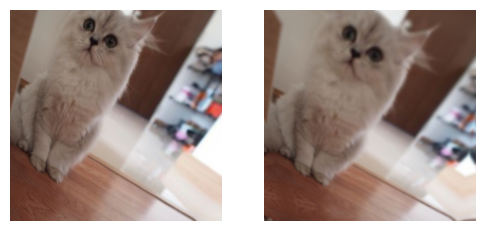

In [20]:
# plot the differences
_,axs = subplots(1, 2)

# fastai transformation (left)
TensorImage(transformed_x[0]).show(ctx=axs[0])

# normal transformation (right)
TensorImage(x1[0]).show(ctx=axs[1]);

# Create CV NN from a pretrained model
ResNet is the pretrained model we're using

## Data

In [21]:
# recall our data is stored in a data downloader
dls

In [22]:
# view one batch of data (batch size = 64)
  # x = pixels of pet images
  # y = true category the pet belongs to, as a number (there are 37 categories)

x,y = dls.one_batch()
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [23]:
# one sample
sample_x = x[0]
sample_y = y[0]

print(sample_x.shape)
print(sample_y)

torch.Size([3, 224, 224])
TensorCategory(21, device='cuda:0')


## Define model architecture (pre-trained model)

In [24]:
# create learner (with pre-trained resnet model)
learn = vision_learner(
  dls, # dataloaders object with data
  resnet34, # pre-trained model
  # opt_func: default
  # loss_func: default
  metrics=error_rate # human metrics
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 127MB/s]


In [25]:
# fine-tune learner (fine_tune instead of fit because we are using a pre-trained model)
n_epochs = 2
learn.fine_tune(n_epochs)

epoch,train_loss,valid_loss,error_rate,time
0,1.498743,0.407385,0.123816,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.545672,0.314171,0.103518,00:39
1,0.321653,0.227695,0.078484,00:39


## Get Y preds
- y preds = the activations of the final layer of our neural network
- these are the predicted pet categories for the images in our mini-batch

### Get all preds

In [26]:
# learn.get_preds returns predicted labels and targets (true labels)
# if we want, we can ignore the targets by using _ (since we already have the targets)
preds, targets = learn.get_preds(dl=[(x,y)]) # recall, x and y are our first batch (defined above)
print(preds.shape)
print(targets.shape)

torch.Size([64, 37])
torch.Size([64])


### Get preds for a single image

In [27]:
# 37 predicted values for each image
  # the probability that the image belongs to each of the 37 pet categories
  # the 37 probabilities will sum to 1

print("true y:", sample_y) # same as target[0]

sample_pred = preds[0]
print(sample_pred.shape)
print(sample_pred.sum())
print(sample_pred[15:18])

true y: TensorCategory(21, device='cuda:0')
torch.Size([37])
tensor(1.0000)
tensor([4.3209e-06, 7.3133e-05, 4.2419e-06])


## Get (human-readable) metrics

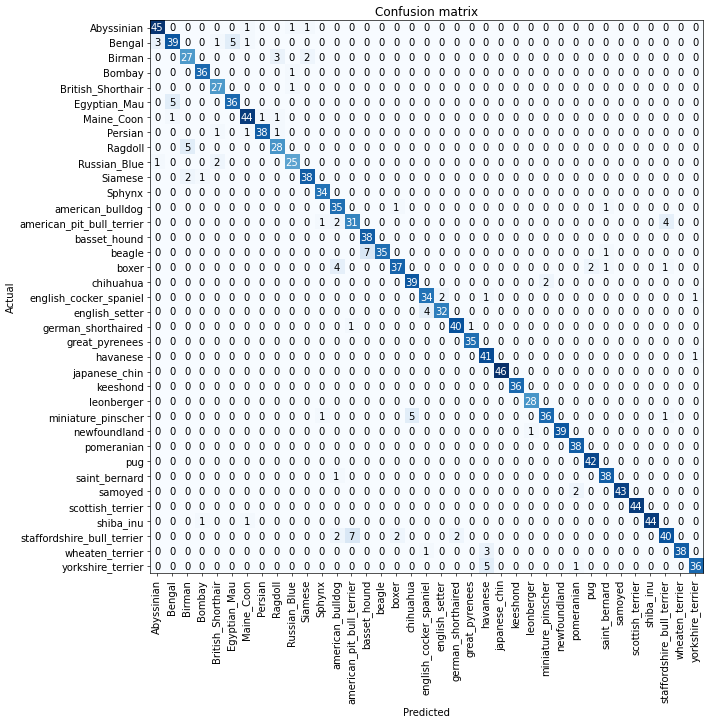

In [28]:
# confusion matrix -- note: this takes a long time to run
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
# show us the cells of the confusion matrix with the most incorrect predictions
# (here, with at least 5 or more incorrect predictions)
interp.most_confused(min_val=5)

[('beagle', 'basset_hound', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('miniature_pinscher', 'chihuahua', 5),
 ('yorkshire_terrier', 'havanese', 5)]

## Get (cross-entropy) loss

Steps of Cross-Entropy Loss Function:
1. Use softmax to scale the activations (aka the predictions for each class) from 0-1 and  ensure the sum of all activations is 1
2. Find the likelihood -- the predicted probability (aka activation) of the correct label
3. Take the negative log of the likelihood

The result of these 3 steps is the cross-entropy loss (aka negative log likelihood loss)


### Aside: Cross-entropy loss in synthetic data
Is this number a 3 or a 7?

#### Data

In [30]:
# let's pretend there are 6 images
# we can define their index (like their id)
synthetic_idx = range(6)

# we can define their "true y label" (aka targets)
synthetic_targets = tensor([0,1,0,1,1,0])

synthetic_idx, synthetic_targets

(range(0, 6), tensor([0, 1, 0, 1, 1, 0]))

#### Y Preds

In [31]:
# create synthetic activations (aka y preds)
  # first column = prediction that the image is a 3
  # second column = prediction that the image is a 7
torch.random.manual_seed(42);
activations = torch.randn((6,2))*2 # (random numbers with a std dev of 2)*2 columns
activations

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [32]:
# look at the sum of the activations by row
  # we want the sum of the activations in each row to be 1
  # that way, it's comparing the probability that an image (aka row)
  # is a 3 (first activation column) or is a 7 (second activation column)

# notice that the sums are not 1
activations.sum(axis=1)

tensor([ 0.9310,  0.9296, -2.6184,  3.1404,  1.4580,  2.6885])

#### Transform Y Preds to be between 0-1

Option 1: Difference values, then sigmoid

In [33]:
# take difference of the two activation columns (aka y preds)
diff_in_preds = (activations[:,0]-activations[:,1])
print(diff_in_preds)

tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])


In [34]:
# use sigmoid function to scale the difference values between 0 and 1
# the smoothed difference reflects how much more sure we are of the input being a 3 than a 7
smoothed_difference = diff_in_preds.sigmoid()
smoothed_difference

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

Option 2: Keep the two activations, then softmax

*This is preferable because it also ensures the sum of all the activations for one row = 1*

Notes about softmax:
- Softmax is the multi-category equivalent of sigmoid
- Intuitively, the softmax function really wants to pick one class among the others, so it's ideal for training a classifier when we know each picture has a definite label
- It may be less ideal during inference, as you might want your model to sometimes tell you it doesn't recognize any of the classes that it has seen during training, and not pick a class because it has a slightly bigger activation score. In this case, it might be better to train a model using multiple binary output columns, each using a sigmoid activation.



In [35]:
# keep the activations as is (two columns: one for 3, one for 7)
activations

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [36]:
# define softmax to smooth the activations
  # note: softmax is the multi-category equivalent of sigmoid
  # goal is still to smooth the values between 0 and 1
  # now the sum of activations (aka y preds) for each row will be 1
def softmax(x):
  return np.exp(x) / np.exp(x).sum(dim=1, keepdim=True)

In [37]:
# run softmax on the activations
  # note: the first column of smoothed_activations here is the same as the smoothed_difference!
  # these smoothed_activations are the relative probability of being a 3 or a 7

smoothed_activations = torch.softmax(activations, dim=1)
print(smoothed_activations)

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])


In [38]:
# note: the sum of activations across each row now = 1
smoothed_activations.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

#### Find the likelihood
- Likelihood = the predicted probability of the correct label
- Compare the true target (y-value) to the activation that corresponds to that target column

One sample

In [39]:
# get the index for one sample
sample_index = synthetic_idx[0]

In [40]:
# get the true target (y value)
  # two possible values: 0 (for an image that is a "3"), 1 (for an image that is a "7")
  # here, the true target is a 0 (the true image is a 3)

sample_y = synthetic_targets[0]
print("real target:",sample_y)

real target: tensor(0)


In [41]:
# get the activations for that sample
  # two activations: one for predicting a 3 and one for predicting a 7

all_activations = smoothed_activations[0]
print("activations for all target classes:",all_activations)

activations for all target classes: tensor([0.6025, 0.3975])


In [42]:
# get the activation for the target class
  # what is the activation (aka prediction) for "is this a 3" (predicting target = 0)
  # this activation corresponds to the first column of the activations

activation_for_target_class = all_activations[sample_y]
print("activation for real target class:",activation_for_target_class)

activation for real target class: tensor(0.6025)


In [43]:
# what is the predicted class -- 0 or 1?
  # choose the activation that is the biggest
predicted_target = torch.argmax(all_activations)
print("predicted target:",predicted_target)

predicted target: tensor(0)


In [44]:
# is the predicted class correct? (same as target class)
correct = (sample_y == predicted_target)
print("is the prediction correct?",correct)

is the prediction correct? tensor(True)


A second sample

In [45]:
# second sample
sample_index = synthetic_idx[1]
sample_y = synthetic_targets[1]
all_activations = smoothed_activations[1]
activation_for_target_class = all_activations[sample_y]
predicted_target = torch.argmax(all_activations)
correct = sample_y == predicted_target

print("real target:",sample_y)
print("activations for all target classes:",all_activations)
print("activation for real target class:",activation_for_target_class)
print("predicted target:",predicted_target)
print("is the prediction correct?",correct)

real target: tensor(1)
activations for all target classes: tensor([0.5021, 0.4979])
activation for real target class: tensor(0.4979)
predicted target: tensor(0)
is the prediction correct? tensor(False)


For all samples

In [46]:
# for all samples, compare the true target to its corresponding activation
activations_for_target_class = smoothed_activations[synthetic_idx, synthetic_targets]

# for all samples, get the predicted target values
predicted_targets = torch.argmax(smoothed_activations, dim=1)

# for each sample, is the predict correct?
correct = synthetic_targets == predicted_targets

print("real target:",synthetic_targets)
print("activations for all target classes:\n",smoothed_activations)
print("activation for real target class:",activations_for_target_class)
print("predicted target:",predicted_targets)
print("is the prediction correct?",correct)

real target: tensor([0, 1, 0, 1, 1, 0])
activations for all target classes:
 tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])
activation for real target class: tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])
predicted target: tensor([0, 0, 1, 0, 0, 1])
is the prediction correct? tensor([ True, False, False, False, False, False])


#### Get the (cross-entropy) loss: the negative log of the likelihood
The negative log just helps ensure that the results of the loss function are positive numbers instead of negative numbers

In [47]:
# recall, result = the predicted probability of the correct label
loss = -torch.log(activations_for_target_class)
loss

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

#### Putting it all together
Get the loss for each image.
Loss is highest when the predictions are confident and wrong

In [48]:
df = pd.DataFrame()
df['index_of_x'] = synthetic_idx
df['true_target'] = synthetic_targets
df['prob_3'] = smoothed_activations[:,0]
df['prob_7'] = smoothed_activations[:,1]
df['prob_correct_target'] = activations_for_target_class
df['predicted_target'] = predicted_targets
df['predicted_target_correct'] = correct
df['cross_entropy_loss'] = loss
df.round(2)

,index_of_x,true_target,prob_3,prob_7,prob_correct_target,predicted_target,predicted_target_correct,cross_entropy_loss
0,0,0,0.60,0.40,0.60,0,True,0.51
1,1,1,0.50,0.50,0.50,0,False,0.70
2,2,0,0.13,0.87,0.13,1,False,2.02
3,3,1,1.00,0.00,0.00,0,False,5.70
4,4,1,0.60,0.40,0.40,0,False,0.91
5,5,0,0.37,0.63,0.37,1,False,1.00


In [49]:
# get the average loss across all images
df['cross_entropy_loss'].mean()

1.8044618

### Cross-entropy loss in pet data

In [50]:
# PyTorch's nn.CrossEntropyLoss does softmax and the negative log likelihood together

# get the mean of the loss for each item
loss_func = nn.CrossEntropyLoss(reduction='none')
all_loss = loss_func(preds, targets)
print(all_loss)

# get the mean of the loss across all items
loss_func = nn.CrossEntropyLoss()
mean_loss = loss_func(preds, targets)
print(mean_loss)

tensor([2.6832, 3.1169, 2.6714, 2.6664, 2.9626, 2.9464, 2.6809, 2.6601, 2.6747, 2.8461, 2.6582, 3.4554, 2.9499, 2.9097, 2.7233, 3.5488, 3.6278, 3.2863, 2.6599, 2.8401, 2.6986, 3.1107, 2.9871, 3.6134,
        2.9195, 3.5541, 2.7273, 2.8469, 2.9569, 3.4079, 3.6166, 3.3079, 3.4171, 3.6422, 2.6711, 2.6574, 3.6423, 2.6613, 2.6608, 2.7033, 2.6613, 3.4147, 2.9135, 2.8247, 3.4085, 2.7015, 2.7872, 3.3736,
        2.8131, 2.6621, 3.5700, 2.6750, 2.6641, 3.2529, 2.6961, 2.8479, 2.9187, 2.7554, 2.8920, 3.5852, 2.6564, 3.6303, 2.6608, 2.6706])
tensor(2.9907)


## Optimize

### Find the best learning rate for the optimization function

Minimum/10: 1.00e-02, steepest point: 5.25e-03


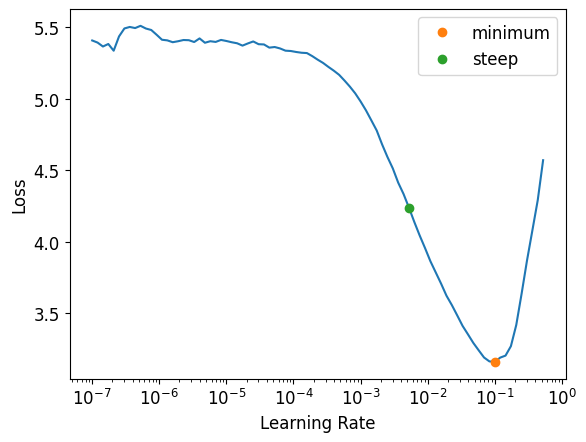

In [51]:
# two ways to do this:
  # One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
  # The last point where the loss was clearly decreasing
# note: the learning rate scale here (x axis) is logarithmic

learn = vision_learner(dls, resnet34, metrics=error_rate) # redefine learner (but no fine-tuning yet)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}");

### Iterate: Fine-tune the resnet model with the best learning rate

In [52]:
lr = 3e-3
n_epochs = 2

learn.fine_tune(n_epochs, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.318459,0.333704,0.117050,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.540940,0.531776,0.152233,00:39
1,0.323894,0.249578,0.079838,00:39


In [53]:
# note: can also optimize the number of epochs, but that takes a very long time

# Aside: Transfer Learning

Using a pre-trained model:
- The first few layers learn things like colors and colors and edges and fur
  - This is useful information for our model
  - We keep these layers (aka freeze them -- keep the weights the same)
- The final linear layer is specific for the task the model that was trained
  - This will not be useful for our model, since the goal is different
  - We need to replace the last layer with a layer that is specific for our task (e.g., classifying pets)
  - We tell the optimizer to only update the weights on this final layer

For epoch 1, fastai:
- keeps all the pre-trained layers frozen except the final layer
- adds random weights for the final layer
- it trains only this randomly-added layer

For epoch 2 onwards, fastai:
- unfreezes the pre-trained layers
- trains on all layers

In [54]:
# customize
# learn.fine_tune??
# learn.fit_one_cycle??

### Unfreezing and Transfer Learning -- Fine-tune final layers manually
Use the same learning rates across the layers


In [55]:
# learner is the same as before
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [56]:
# train the randomly added layers for 3 cycles
# it knows resnet is a pre-trained model, so all except the final layer are frozen
n_epochs = 3
lr = 3e-3
learn.fit_one_cycle(n_epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.171585,0.313738,0.102842,00:32
1,0.529171,0.232241,0.077131,00:32
2,0.316484,0.214766,0.068336,00:32


In [57]:
# unfreeze the pre-trained model
learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

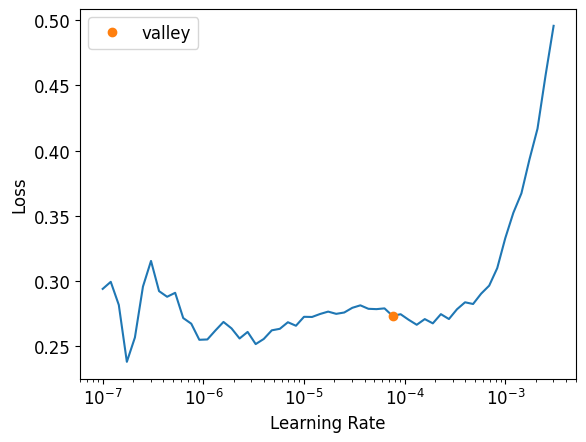

In [58]:
# find the best learning rate (since we have more layers to train now)
# shape is different because the model has already been trained
learn.lr_find()

In [59]:
# fine-tune with updated learning rate
n_epochs = 6
lr = 1e-4
learn.fit_one_cycle(n_epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.255990,0.241097,0.079161,00:40
1,0.295645,0.318206,0.099459,00:40
2,0.255656,0.309812,0.089986,00:40
3,0.188165,0.242274,0.068336,00:40
4,0.120265,0.198002,0.059540,00:40
5,0.098493,0.191000,0.058863,00:40


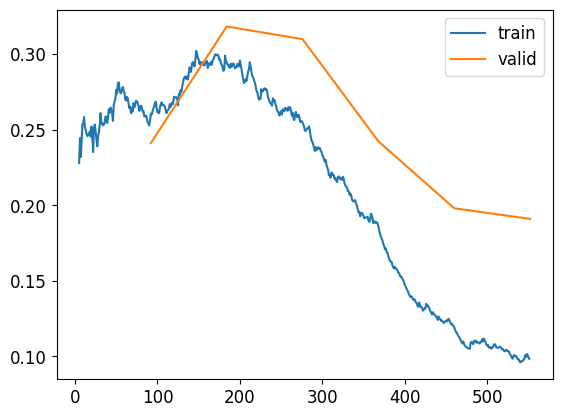

In [60]:
# evaluate
learn.recorder.plot_loss()

### Unfreezing and Transfer Learning -- Fine-tune final layers discriminatively
Discriminative Learning Rates -- Different learning rates for different layers
- The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task.
- The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.
- ULMFiT approach: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers)

In [61]:
# learner is the same as before
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [62]:
# train the randomly added layers for 3 cycles
n_epochs = 3
lr = 3e-3
learn.fit_one_cycle(n_epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.147153,0.312690,0.105548,00:32
1,0.525104,0.258145,0.086604,00:32
2,0.331695,0.213079,0.069012,00:32


In [63]:
# unfreeze the pre-trained model
learn.unfreeze()

In [64]:
# find discriminative learning rates
  # first value = learning rate in the earliest layer of the neural network
  # second value = learning rate in the final layer
  # the layers in between will have learning rates that are multiplicatively equidistant throughout that range

# smaller learning rate for earlier layers than later layers
disc_learning_rates = slice(1e-6,1e-4)
print(disc_learning_rates)

slice(1e-06, 0.0001, None)


In [65]:
# fine-tune with updated learning rate
n_epochs = 12
learn.fit_one_cycle(n_epochs, lr_max = disc_learning_rates)

epoch,train_loss,valid_loss,error_rate,time
0,0.270037,0.209211,0.067659,00:40
1,0.257004,0.212977,0.067659,00:40
2,0.239969,0.208017,0.067659,00:40
3,0.205251,0.204321,0.064276,00:40
4,0.182806,0.196206,0.067659,00:40
5,0.158627,0.202706,0.069689,00:40
6,0.163069,0.194525,0.067659,00:40
7,0.144246,0.194830,0.067659,00:40
8,0.131822,0.190108,0.062923,00:40
9,0.121314,0.189178,0.064276,00:40


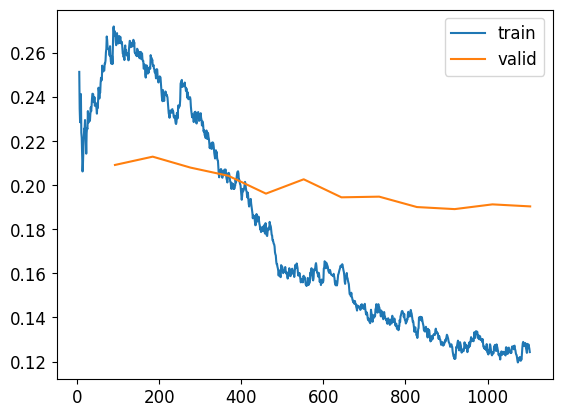

In [66]:
# evaluate (training and validation loss)
  # note we are overfitting by the end
  # if you find that you have overfit, what you should do is retrain your model from scratch,
  # and this time select a total number of epochs based on where your previous best results were found
learn.recorder.plot_loss()

#### Unfreezing and Transfer Learning -- Fine-tune final layers automatically

In [67]:
# learner is the same
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [68]:
# fine-tune automatically
  # freeze_epochs = how many epochs to train for while frozen
  # the freeze_epochs function will automatically change learning rates appropriately
n_epochs = 6
num_freeze = 3
learn.fine_tune(n_epochs, freeze_epochs=num_freeze)

epoch,train_loss,valid_loss,error_rate,time
0,2.573562,0.553458,0.162382,00:32
1,0.927480,0.306106,0.105548,00:32
2,0.534144,0.303258,0.097429,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.347953,0.239965,0.079161,00:40
1,0.327112,0.325185,0.098106,00:40
2,0.273893,0.291016,0.082544,00:40
3,0.202006,0.262228,0.083221,00:40
4,0.119838,0.240300,0.075778,00:40
5,0.075917,0.240912,0.077131,00:40


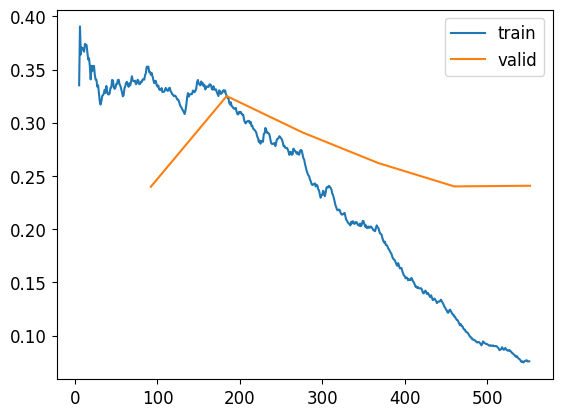

In [69]:
# evaluate
learn.recorder.plot_loss()

# Choose a Deeper Model
- More layers (deeper) can lead to overfitting
- Also can run out of GPU RAM, so you might need to lower the batch size
- Take longer to train (mixed-precision training, the `to_fp16` below) helps with this. This is fast.api's way to enable NVIDIA GPUs tensor cores (speed up N training)

## Learner

In [70]:
from fastai.callback.fp16 import *

learn = vision_learner(
  dls,
  resnet50, # notice 50 layers now (more than before)
  metrics=error_rate
).to_fp16() # uses less-precise numbers (half-precision floating point): faster

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [71]:
# fine-tune automatically
n_epochs = 6
num_freeze = 3 # how many epochs to train for while frozen
learn.fine_tune(n_epochs, freeze_epochs=num_freeze)

epoch,train_loss,valid_loss,error_rate,time
0,2.219512,0.435912,0.132612,00:31
1,0.866283,0.322264,0.095399,00:30
2,0.576356,0.292031,0.100812,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.280685,0.241945,0.074425,00:35
1,0.251842,0.228331,0.069012,00:35
2,0.186631,0.222610,0.061570,00:35
3,0.123285,0.213902,0.060893,00:34
4,0.086897,0.186904,0.050744,00:35
5,0.065443,0.182714,0.051421,00:34
